Original Series:
ADF Statistic: -2.7863
p-value: 0.0603
❌ Not stationary — differencing needed.


c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Val

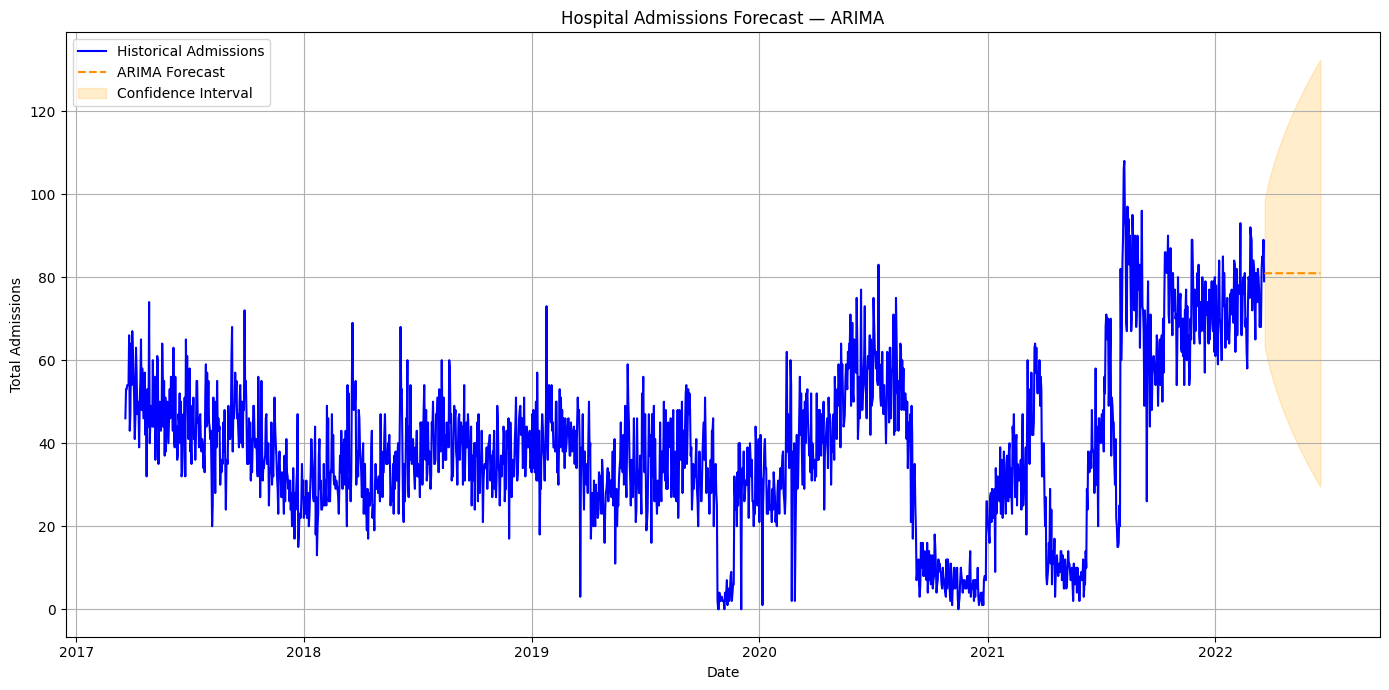


Forecast Preview:
           Date  Forecasted_Admissions  Lower_Bound  Upper_Bound
1819 2022-03-21                  80.71        63.45        97.97
1820 2022-03-22                  80.92        62.43        99.41
1821 2022-03-23                  80.95        61.72       100.18
1822 2022-03-24                  80.95        61.05       100.85
1823 2022-03-25                  80.95        60.40       101.50
1824 2022-03-26                  80.95        59.77       102.13
1825 2022-03-27                  80.95        59.17       102.73
1826 2022-03-28                  80.95        58.57       103.33
1827 2022-03-29                  80.95        58.00       103.90
1828 2022-03-30                  80.95        57.44       104.47
1829 2022-03-31                  80.95        56.89       105.01
1830 2022-04-01                  80.95        56.35       105.55
1831 2022-04-02                  80.95        55.82       106.08
1832 2022-04-03                  80.95        55.31       106.59
1833 2

c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Val

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Step 1: Load data ===
hospital_data = pd.read_csv("/finalproject/feature_engineering/time_series_data.csv")

hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
hospital_data.set_index('ResidentDate', inplace=True)

# === Step 2: Define target variable ===
y = hospital_data['Total_Admissions']

# === Step 3: Stationarity check ===
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print(" Stationary time series.")
    else:
        print(" Not stationary — differencing needed.")

print("Original Series:")
test_stationarity(y)

# === Step 4: Fit ARIMA Model ===
# ARIMA(p,d,q) — d=1 if not stationary
p, d, q = 1, 1, 1  # Typical starter values
arima_model = ARIMA(y, order=(p, d, q))
arima_results = arima_model.fit()

# === Step 5: Forecasting ===
forecast_steps = 90

# Forecasting the next 90 steps
forecast = arima_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# === Step 6: Visualization ===
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Historical Admissions', color='blue')
plt.plot(forecast_index, forecast_mean, label='ARIMA Forecast', color='darkorange', linestyle='--')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.2, label='Confidence Interval')
plt.title('Hospital Admissions Forecast — ARIMA')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 7: Print Forecast Table ===
forecast_table = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Admissions': forecast_mean.round(2),
    'Lower_Bound': forecast_ci.iloc[:, 0].round(2),
    'Upper_Bound': forecast_ci.iloc[:, 1].round(2)
})

print("\nForecast Preview:")
print(forecast_table.head(15))

# === Step 8: Calculate Performance Metrics ===
# For performance metrics, we need to split the data into training and testing sets
train_size = int(len(hospital_data) * 0.8)  # 80% for training
train, test = hospital_data.iloc[:train_size], hospital_data.iloc[train_size:]

# Define target variable for training and testing
y_train = train['Total_Admissions']
y_test = test['Total_Admissions']

# Fit the ARIMA model on the training data
arima_model = ARIMA(y_train, order=(p, d, q))
arima_results = arima_model.fit()

# Forecast on the test set
forecast = arima_results.get_forecast(steps=len(y_test))
forecast_mean = forecast.predicted_mean

# Calculate performance metrics
mae = mean_absolute_error(y_test, forecast_mean)
mse = mean_squared_error(y_test, forecast_mean)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

